# Validation

OpenFisca-UK runs unit and integration tests on each new version (see [here](https://github.com/PSLmodels/openfisca-uk/tree/master/tests)).
In addition, the table below shows the aggregates produced by the model for the major taxes and benefits, and comparisons with UKMOD (latest [country report](https://www.iser.essex.ac.uk/research/publications/working-papers/cempa/cempa7-20.pdf)) and official sources.[^1]
UKMOD and administrative sources refer to 2018, and OpenFisca-UK is simulated on policy at the end of 2018.
Numbers are in billions of pounds.

[^1]: From the UKMOD country report: unless otherwise specified: Department for Work and Pensions https://www.gov.uk/government/publications/benefit-expenditure-and-caseload-tables-2018 ; Best Start Grant: https://www2.gov.scot/Topics/Statistics/Browse/Social-Welfare/SocialSecurityforScotland/BSGJune2019; Child tax credit and working tax credit: HMRC statistics 
https://www.gov.uk/government/statistics/child-and-working-tax-credits-statistics-finalised-annual-awards-2016-to-2017; Scottish Child Payment: Scottish Fiscal Commission https://www.fiscalcommission.scot/forecast/supplementary-costing-scottish-child-payment; Scottish Child Winter Heating Assistance: Scottish Fiscal Commission 
https://www.fiscalcommission.scot/forecast/supplementary-costing-child-winter-heating-assistance; Income tax: HMRC statistics https://www.gov.uk/government/statistics/income-tax-liabilities-statistics-tax-year-2014-to-2015-to-tax-year-2017-to-2018; National Insurance Contributions: ONS Blue Book Table 5.2.4s 

## Aggregate tables

OpenFisca-UK uprates input FRS data: below are comparisons between the aggregates calculated by OpenFisca-UK, UKMOD and external sources.

### Aggregates in full

In [1]:
import numpy as np
import pandas as pd
from openfisca_uk import Microsimulation, variables as default_variables, REPO, parameters
from openfisca_core.parameters import ParameterNode
from pathlib import Path
import yaml
import plotly.express as px

OPENFISCA_UK = "OpenFisca-UK"
UKMOD = "UKMOD"
EXTERNAL = "External"

VARIABLES = [
    "child_benefit",
    "ESA_income",
    "income_support",
    "JSA_income",
    "housing_benefit",
    "working_tax_credit",
    "child_tax_credit",
    "universal_credit",
    "pension_credit",
    "income_tax",
    "total_NI",
]

sim = Microsimulation()

# https://stackoverflow.com/questions/34667108/ignore-dates-and-times-while-parsing-yaml

yaml.SafeLoader.yaml_implicit_resolvers = {
    k: [r for r in v if r[0] != 'tag:yaml.org,2002:timestamp'] for
    k, v in yaml.SafeLoader.yaml_implicit_resolvers.items()
}

with open(REPO.parent / "docs" / "book" / "model" / "ukmod_country_report_statistics.yaml", mode="r") as f:
    ukmod_statistics = ParameterNode("ukmod", data=yaml.load(f, Loader=yaml.SafeLoader))
    
def process_scalar(x, divisor, decimals):
    if np.isnan(x):
        return x
    return round(x / divisor, decimals)

def model_validation_table(
    model_year_variable_to_result_func,
    title=None,
    start_year=2019,
    end_year=2025,
    divisor=1,
    decimals=0,
    models=[EXTERNAL, OPENFISCA_UK, UKMOD],
    variables=VARIABLES,
):
    dfs = []
    for model in models:
        df = pd.DataFrame({
            year: {
                default_variables[variable].label: process_scalar(model_year_variable_to_result_func(model, year, variable), divisor, decimals)
                for variable in variables
            } for year in range(start_year, end_year + 1)
        })
        dfs.append(df.T)
    return pd.concat(dfs, keys=models).replace(np.nan, "")

def budgetary_impact(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return sim.calc(variable, map_to="household", period=year).sum()
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.budgetary_impact, variable)(f"{year}-01-01")
        elif model == EXTERNAL:
            return getattr(parameters.calibration.budgetary_impact.by_program, variable)(f"{year}-01-01")
    except:
        return np.nan

In [2]:
model_validation_table(budgetary_impact, divisor=1e9, decimals=1)

Child Benefit  ESA (income-based) Income Support  \
External     2019           11.1                 9.3            1.4   
             2020           11.1                 8.8            1.1   
             2021           11.0                 8.3            0.9   
             2022           11.2                 8.2            0.7   
             2023           11.5                 7.8            0.5   
             2024           11.6                 6.4            0.5   
             2025           11.6                 3.5            0.4   
OpenFisca-UK 2019           11.5                 7.2            1.8   
             2020           11.5                 6.9            1.4   
             2021           11.5                 3.4            1.0   
             2022           11.5                 3.3            0.8   
             2023           11.7                 3.1            0.5   
             2024           12.2                 2.4            0.4   
             2025           12.7                 1.2            0.2   
UKMOD        2019           11.3                 6.1                  
             2020           11.5                 5.5                  
             2021           11.7                 4.8                  
             2022           12.0                 4.2                  
             2023           12.3                 3.7                  
             2024           12.5                 2.7                  
             2025           12.6                 1.2                  

                  JSA (income-based)  Housing Benefit  Working Tax Credit  \
External     2019                0.6             18.4                 3.8   
             2020                0.4             17.3                 3.1   
             2021                0.3             17.1                 2.2   
             2022                0.2             15.9                 1.6   
             2023                0.0             14.7                 1.2   
             2024                0.0             12.5                 0.8   
             2025                0.0             10.2                 0.4   
OpenFisca-UK 2019                0.5             11.1                 3.6   
             2020                0.4             10.0                 2.9   
             2021                0.3              9.8                 3.1   
             2022                0.2              9.3                 2.1   
             2023                0.0              8.8                 1.7   
             2024                0.3              8.0                 1.4   
             2025                0.3              6.9                 0.9   
UKMOD        2019                                12.6                 2.1   
             2020                                12.3                 2.4   
             2021                                11.0                 2.1   
             2022                                10.3                 1.6   
             2023                                 9.6                 1.3   
             2024                                 8.5                 0.9   
             2025                                 6.7                 0.4   

                   Child Tax Credit  Universal Credit  Pension Credit  \
External     2019              13.9              18.4             5.1   
             2020              11.4              38.3             5.1   
             2021               8.1              41.1             5.0   
             2022               6.0              43.7             4.5   
             2023               4.5              49.8             4.4   
             2024               3.0              57.8             4.4   
             2025               1.3              68.0             4.2   
OpenFisca-UK 2019              14.4              16.2             2.8   
             2020              11.1              32.0             2.7   
             2021              

### Differences

#### Absolute

In [3]:
def budgetary_impact_error(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return sim.calc(variable, map_to="household", period=year).sum() - budgetary_impact(EXTERNAL, year, variable)
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.budgetary_impact, variable)(f"{year}-01-01") - budgetary_impact(EXTERNAL, year, variable)
    except:
        return np.nan

model_validation_table(budgetary_impact_error, models=[OPENFISCA_UK, UKMOD], divisor=1e9, decimals=1)

Child Benefit  ESA (income-based) Income Support  \
OpenFisca-UK 2019            0.4                -2.1            0.4   
             2020            0.4                -1.9            0.3   
             2021            0.5                -4.9            0.2   
             2022            0.3                -5.0            0.1   
             2023            0.1                -4.8            0.1   
             2024            0.5                -4.0           -0.1   
             2025            1.1                -2.3           -0.2   
UKMOD        2019            0.3                -3.2                  
             2020            0.4                -3.3                  
             2021            0.7                -3.5                  
             2022            0.8                -4.0                  
             2023            0.8                -4.2                  
             2024            0.9                -3.7                  
             2025            1.0                -2.3                  

                  JSA (income-based)  Housing Benefit  Working Tax Credit  \
OpenFisca-UK 2019               -0.1             -7.3                -0.2   
             2020               -0.1             -7.4                -0.2   
             2021                0.0             -7.3                 0.8   
             2022                0.0             -6.6                 0.4   
             2023               -0.0             -6.0                 0.5   
             2024                0.3             -4.5                 0.6   
             2025                0.3             -3.3                 0.5   
UKMOD        2019                                -5.8                -1.7   
             2020                                -5.0                -0.7   
             2021                                -6.2                -0.1   
             2022                                -5.6                -0.1   
             2023                                -5.1                 0.1   
             2024                                -4.0                 0.1   
             2025                                -3.5                 0.1   

                   Child Tax Credit  Universal Credit  Pension Credit  \
OpenFisca-UK 2019               0.6              -2.2            -2.2   
             2020              -0.3              -6.3            -2.3   
             2021               0.7              -4.3            -2.1   
             2022               1.1              -6.0            -1.7   
             2023               1.2              -7.8            -1.9   
             2024               1.3              -9.7            -1.9   
             2025               1.3             -12.6            -1.9   
UKMOD        2019              -5.4              -1.0            -0.6   
             2020              -3.6             -11.9            -0.5   
             2021              -1.6             -11.3            -0.9   
             2022              -0.6              -9.6            -0.3   
             2023               0.1             -10.6            -0.0   
             2024               0.3             -18.6             0.1   
             2025               0.1             -22.3             0.2   

                   Income Tax  National Insurance (total)  
OpenFisca-UK 2019       -25.4                        -1.5  
             2020       -23.7                         2.6  
             2021       -29.1                         2.0  
             2022       -26.9                         0.5  
             2023       -28.0                        -1.0  
             2024       -29.8                        -3.6  
             2025       -31.6                        -6.9  
UKMOD        2019       -30.3                         4.4  
             2020       -29.0                         0.0  
             2021       -51.2                        -8.2  
             2022       -43.8            

#### Relative

In [4]:
def relative_budgetary_impact_error(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return sim.calc(variable, map_to="household", period=year).sum() / budgetary_impact(EXTERNAL, year, variable) - 1
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.budgetary_impact, variable)(f"{year}-01-01") / budgetary_impact(EXTERNAL, year, variable) - 1
    except:
        return np.nan

model_validation_table(relative_budgetary_impact_error, models=[OPENFISCA_UK, UKMOD], divisor=1e-2, decimals=1)

Child Benefit  ESA (income-based) Income Support  \
OpenFisca-UK 2019            3.4               -22.7           29.6   
             2020            3.7               -21.7           25.6   
             2021            5.0               -58.8           22.9   
             2022            2.3               -60.3           12.7   
             2023            1.2               -60.8           10.4   
             2024            4.6               -62.1          -12.7   
             2025            9.6               -64.7          -44.7   
UKMOD        2019            2.3               -34.2                  
             2020            3.8               -37.4                  
             2021            6.6               -42.2                  
             2022            6.7               -48.8                  
             2023            6.8               -53.2                  
             2024            7.9               -57.9                  
             2025            8.2               -65.1                  

                  JSA (income-based)  Housing Benefit  Working Tax Credit  \
OpenFisca-UK 2019              -20.9            -39.5                -5.2   
             2020              -15.0            -42.6                -6.0   
             2021                1.5            -42.7                37.5   
             2022                2.9            -41.4                25.3   
             2023             -100.0            -40.6                41.1   
             2024                inf            -36.1                69.7   
             2025                inf            -32.5               144.9   
UKMOD        2019                               -31.7               -44.1   
             2020                               -28.9               -23.2   
             2021                               -36.0                -5.4   
             2022                               -35.0                -4.3   
             2023                               -34.7                 6.5   
             2024                               -32.2                10.2   
             2025                               -34.3                14.6   

                   Child Tax Credit  Universal Credit  Pension Credit  \
OpenFisca-UK 2019               4.1             -11.9           -43.8   
             2020              -2.9             -16.5           -46.0   
             2021               8.3             -10.4           -41.6   
             2022              18.1             -13.8           -38.0   
             2023              25.8             -15.7           -43.2   
             2024              43.3             -16.9           -44.2   
             2025              95.6             -18.6           -44.6   
UKMOD        2019             -39.1              -5.3           -12.2   
             2020             -31.9             -31.0           -10.2   
             2021             -19.2             -27.4           -18.4   
             2022             -10.2             -22.0            -7.0   
             2023               1.1             -21.3            -0.8   
             2024              11.4             -32.3             2.6   
             2025               9.1             -32.8             5.8   

                   Income Tax  National Insurance (total)  
OpenFisca-UK 2019       -13.1                        -1.0  
             2020       -12.6                         1.9  
             2021       -14.3                         1.4  
             2022       -13.1                         0.3  
             2023       -13.0                        -0.6  
             2024       -13.2                        -2.2  
             2025       -13.3                        -4.0  
UKMOD        2019       -15.7                         3.0  
             2020       -15.4                         0.0  
             2021       -25.1                        -5.6  
             2022       -21.4            

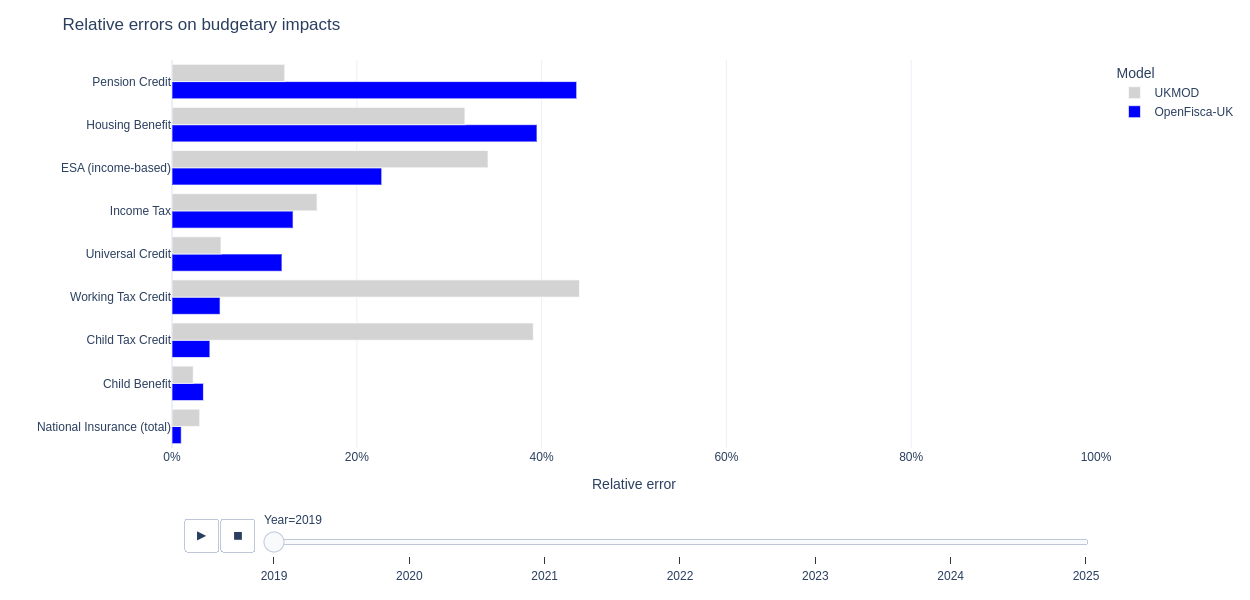

In [18]:
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)

def error_chart(table, title=None):
    hovertemplate = "<b>%{customdata[4]} in %{customdata[3]}</b><br>Error: %{x}<br>Official: £%{customdata[2]}bn<br>OpenFisca-UK: £%{customdata[0]}bn<br>UKMOD: £%{customdata[1]}bn"
    table = table.replace("", np.nan).dropna(axis=0)
    table[[OPENFISCA_UK, UKMOD]] = table[[OPENFISCA_UK, UKMOD]].abs() / 1e2
    fig = (
        px.bar(
            table.sort_values(["Year", OPENFISCA_UK]),
            x=[OPENFISCA_UK, UKMOD],
            y="Program",
            orientation="h",
            animation_frame="Year",
            barmode="group",
            color_discrete_map={
                OPENFISCA_UK: "blue",
                UKMOD: "lightgrey",
            },
            custom_data=[
                "OpenFisca-UK budgetary impact",
                "UKMOD budgetary impact",
                "External budgetary impact",
                "Year",
                "Program",
            ],
        )
        .update_layout(
            width=800,
            height=600,
            xaxis_tickformat=".0%",
            xaxis_title="Relative error",
            title=title,
            xaxis_range=(0, 1),
            template="plotly_white",
            legend_title="Model",
            yaxis_title="",
            legend_traceorder="reversed",
        )
        .update_traces(hovertemplate=hovertemplate)
    )
    for frame in fig.frames:
        for data in frame.data:
            data.hovertemplate = hovertemplate
    return fig

def table_to_model_comparison(table):
    df = table.reset_index()
    df.columns = ["Model", "Year"] + list(table.columns)
    return pd.melt(df, id_vars=["Year", "Model"]).pivot(index=["Year", "variable"], columns="Model", values="value").reset_index().rename(columns=dict(variable="Program"))
 
def tables_to_model_comparisons(tables):
    dfs = []
    for key, table in tables.items():
        df = table_to_model_comparison(table)
        df = df.rename(columns={column: f"{column} {key}" if key != "" and column not in ("Year", "Model", "Program") else column for column in df.columns})
        dfs.append(df)
    df = pd.concat(dfs, axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    return df

error_chart(
    tables_to_model_comparisons(
        {
            "": model_validation_table(relative_budgetary_impact_error, models=[OPENFISCA_UK, UKMOD], divisor=1e-2, decimals=1),
            "budgetary impact": model_validation_table(budgetary_impact, divisor=1e9, decimals=1),
        }
    ),
    title="Relative errors on budgetary impacts"
)

## Caseload tables

OpenFisca-UK uprates input FRS data: below are comparisons between the aggregates calculated by OpenFisca-UK, UKMOD and external sources.

### Caseloads in full

In [6]:
def caseload(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return (sim.calc(variable, period=year) > 0).sum()
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.nonzero_units, variable)(f"{year}-01-01")
        elif model == EXTERNAL:
            try:
                return getattr(parameters.calibration.families.by_program_participation, variable)(f"{year}-01-01")
            except:
                return getattr(parameters.calibration.populations.by_program_participation, variable)(f"{year}-01-01")
    except:
        return np.nan

model_validation_table(caseload, models=[EXTERNAL, OPENFISCA_UK, UKMOD], divisor=1e6, decimals=1)

Child Benefit  ESA (income-based) Income Support  \
External     2019  7.3            1.1                 0.4             
             2020  7.2            1.0                 0.3             
             2021  7.1            0.4                 0.2             
             2022  7.1            0.4                 0.2             
             2023  7.0            0.3                 0.1             
             2024  6.9            0.3                 0.1             
             2025  6.9            0.1                 0.0             
OpenFisca-UK 2019  6.9            0.9                 0.3             
             2020  6.9            0.8                 0.2             
             2021  6.8            0.4                 0.2             
             2022  6.8            0.4                 0.1             
             2023  6.7            0.4                 0.1             
             2024  6.7            0.3                 0.1             
             2025  6.7            0.1                 0.0             
UKMOD        2019  7.1            0.9                                 
             2020  7.1            0.8                                 
             2021  7.2            0.7                                 
             2022  7.1            0.6                                 
             2023  7.1            0.5                                 
             2024  7.0            0.3                                 
             2025  7.0            0.1                                 

                  JSA (income-based)  Housing Benefit  Working Tax Credit  \
External     2019  0.1                3.4              1.6                  
             2020  0.1                3.0              1.2                  
             2021  0.1                2.9              1.0                  
             2022  0.0                2.7              0.9                  
             2023  0.0                2.5              0.8                  
             2024  0.0                2.1              0.7                  
             2025  0.0                1.7              0.6                  
OpenFisca-UK 2019  0.1                2.5              1.1                  
             2020  0.1                2.2              0.9                  
             2021  0.1                2.2              0.8                  
             2022  0.0                2.0              0.7                  
             2023  0.0                1.9              0.6                  
             2024  0.1                1.7              0.4                  
             2025  0.0                1.4              0.3                  
UKMOD        2019                     2.9              0.8                  
             2020                     2.7              0.6                  
             2021                     2.4              0.7                  
             2022                     2.3              0.5                  
             2023                     2.0              0.4                  
             2024                     1.8              0.3                  
             2025                     1.4              0.1                  

                   Child Tax Credit  Universal Credit  Pension Credit  \
External     2019  2.8               2.1               1.6              
             2020  2.1               4.1               1.5              
             2021  1.7               4.3               1.5              
             2022  1.3               4.6               1.4              
             2023  1.1               5.0               1.3              
             2024  0.8               5.6               1.3              
             2025  0.7               6.3               1.2              
OpenFisca-UK 2019  2.2               1.7               1.2              
             2020  1.7               3.1               1.2              
             2021  1.4         

### Differences

#### Absolute

In [7]:
def caseload_error(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return (sim.calc(variable, period=year) > 0).sum() - caseload(EXTERNAL, year, variable)
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.nonzero_units, variable)(f"{year}-01-01") - caseload(EXTERNAL, year, variable)
    except:
        return np.nan

model_validation_table(caseload_error, variables=VARIABLES[:-1], models=[OPENFISCA_UK, UKMOD], divisor=1e6, decimals=1)

Child Benefit  ESA (income-based) Income Support  \
OpenFisca-UK 2019 -0.4           -0.2                -0.0             
             2020 -0.3           -0.1                -0.0             
             2021 -0.3            0.0                -0.0             
             2022 -0.3            0.0                -0.0             
             2023 -0.3            0.0                -0.0             
             2024 -0.2            0.0                -0.0             
             2025 -0.2            0.0                -0.0             
UKMOD        2019 -0.2           -0.2                                 
             2020 -0.1           -0.2                                 
             2021  0.0            0.3                                 
             2022  0.0            0.2                                 
             2023  0.1            0.1                                 
             2024  0.1            0.1                                 
             2025  0.1            0.0                                 

                  JSA (income-based)  Housing Benefit  Working Tax Credit  \
OpenFisca-UK 2019 -0.0               -0.9             -0.5                  
             2020 -0.0               -0.8             -0.3                  
             2021 -0.0               -0.8             -0.3                  
             2022 -0.0               -0.7             -0.3                  
             2023 -0.0               -0.6             -0.2                  
             2024  0.1               -0.4             -0.2                  
             2025  0.0               -0.3             -0.3                  
UKMOD        2019                    -0.5             -0.8                  
             2020                    -0.3             -0.6                  
             2021                    -0.5             -0.4                  
             2022                    -0.4             -0.4                  
             2023                    -0.4             -0.3                  
             2024                    -0.3             -0.4                  
             2025                    -0.3             -0.5                  

                   Child Tax Credit  Universal Credit  Pension Credit  \
OpenFisca-UK 2019 -0.6              -0.4              -0.3              
             2020 -0.4              -0.9              -0.3              
             2021 -0.3              -1.0              -0.3              
             2022 -0.2              -1.0              -0.3              
             2023 -0.1              -1.1              -0.2              
             2024 -0.2              -1.3              -0.2              
             2025 -0.2              -1.5              -0.2              
UKMOD        2019 -1.1              -0.0              -0.0              
             2020 -0.6              -0.9               0.1              
             2021 -0.4              -0.7              -0.1              
             2022 -0.3              -0.4               0.0              
             2023 -0.2              -0.4               0.1              
             2024 -0.2              -0.3               0.2              
             2025 -0.4              -0.1               0.2              

                   Income Tax  
OpenFisca-UK 2019 -3.2         
             2020 -4.5         
             2021 -3.9         
             2022 -3.6         
             2023 -3.3         
             2024 -2.7         
             2025 -2.3         
UKMOD        2019  8.5         
             2020 -2.2         
             2021 -2.8         
             2022 -2.7         
             2023 -2.6         
             2024 -2.8         
             2025 -2.8

#### Relative

In [8]:
def relative_caseload_error(model, year, variable):
    try:
        if model == OPENFISCA_UK:
            return (sim.calc(variable, period=year) > 0).sum() / caseload(EXTERNAL, year, variable) - 1
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.nonzero_units, variable)(f"{year}-01-01") / caseload(EXTERNAL, year, variable) - 1
    except:
        return np.nan

model_validation_table(relative_caseload_error, variables=VARIABLES[:-1], models=[OPENFISCA_UK, UKMOD], divisor=1e-2, decimals=1)

Child Benefit  ESA (income-based) Income Support  \
OpenFisca-UK 2019 -5.5           -15.8               -10.3            
             2020 -4.4           -13.1               -11.1            
             2021 -4.4            1.8                -9.5             
             2022 -4.0            2.9                -11.7            
             2023 -3.7            4.1                -14.5            
             2024 -3.3            4.6                -12.3            
             2025 -2.6            5.3                -5.1             
UKMOD        2019 -2.5           -15.6                                
             2020 -1.6           -17.5                                
             2021  0.3            72.2                                
             2022  0.6            55.8                                
             2023  1.0            42.2                                
             2024  1.3            29.5                                
             2025  1.8            10.6                                

                  JSA (income-based)  Housing Benefit  Working Tax Credit  \
OpenFisca-UK 2019 -24.3              -26.3            -31.9                 
             2020 -15.2              -26.6            -25.2                 
             2021 -7.7               -26.4            -25.1                 
             2022 -4.3               -24.6            -27.9                 
             2023 -100.0             -23.1            -30.2                 
             2024  inf               -20.0            -35.1                 
             2025  inf               -16.7            -47.6                 
UKMOD        2019                    -14.2            -49.8                 
             2020                    -11.3            -48.2                 
             2021                    -16.7            -36.4                 
             2022                    -16.5            -40.6                 
             2023                    -16.6            -44.0                 
             2024                    -15.7            -56.9                 
             2025                    -17.0            -78.5                 

                   Child Tax Credit  Universal Credit  Pension Credit  \
OpenFisca-UK 2019 -22.9             -20.1             -20.1             
             2020 -18.8             -23.1             -20.6             
             2021 -17.2             -22.9             -18.7             
             2022 -14.3             -22.1             -17.9             
             2023 -14.1             -21.7             -17.3             
             2024 -17.9             -22.4             -17.9             
             2025 -31.4             -23.5             -18.8             
UKMOD        2019 -38.7             -0.2              -2.6              
             2020 -30.4             -22.3              4.5              
             2021 -22.2             -16.4             -3.9              
             2022 -19.3             -9.4               0.5              
             2023 -16.1             -7.8               7.8              
             2024 -23.6             -5.2               12.3             
             2025 -56.3             -2.2               14.9             

                   Income Tax  
OpenFisca-UK 2019 -10.1        
             2020 -14.2        
             2021 -12.1        
             2022 -11.1        
             2023 -9.8         
             2024 -7.9         
             2025 -6.6         
UKMOD        2019  26.9        
             2020 -6.8         
             2021 -8.6         
             2022 -8.2         
             2023 -7.9         
             2024 -8.3         
             2025 -8.2

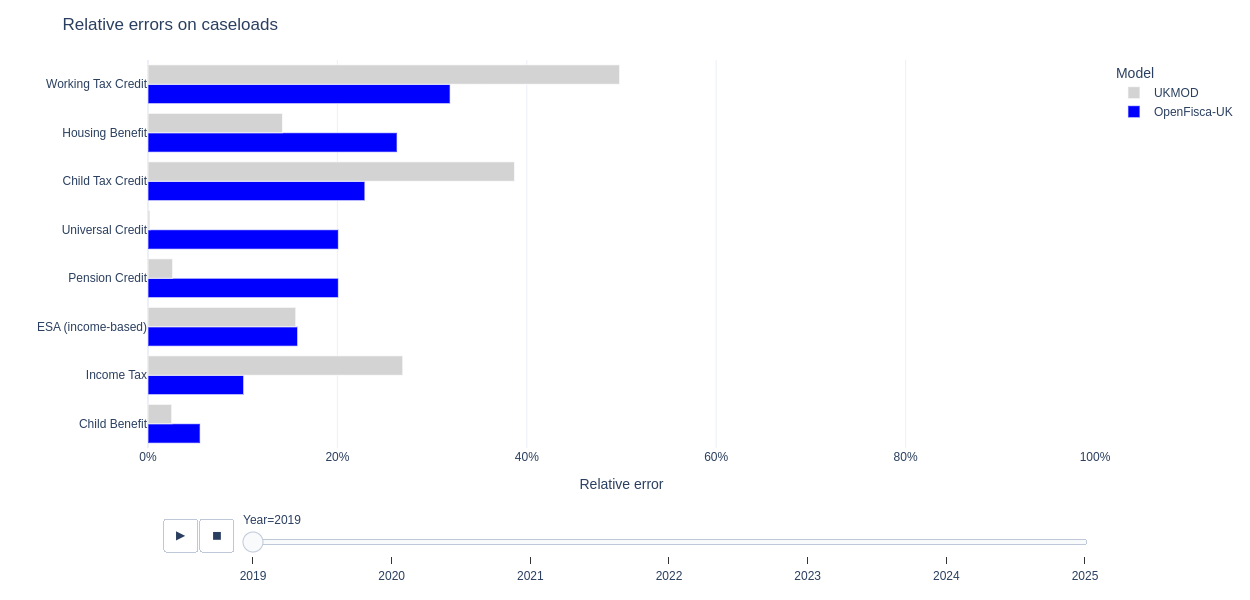

In [21]:
def error_chart(table, title=None):
    hovertemplate = "<b>%{customdata[4]} in %{customdata[3]}</b><br>Error: %{x}<br>Official: %{customdata[2]}m<br>OpenFisca-UK: %{customdata[0]}m<br>UKMOD: %{customdata[1]}m"
    table = table.replace("", np.nan).dropna(axis=0)
    table[[OPENFISCA_UK, UKMOD]] = table[[OPENFISCA_UK, UKMOD]].abs() / 1e2
    fig = (
        px.bar(
            table.sort_values(["Year", OPENFISCA_UK]),
            x=[OPENFISCA_UK, UKMOD],
            y="Program",
            orientation="h",
            animation_frame="Year",
            barmode="group",
            color_discrete_map={
                OPENFISCA_UK: "blue",
                UKMOD: "lightgrey",
            },
            custom_data=[
                "OpenFisca-UK caseload",
                "UKMOD caseload",
                "External caseload",
                "Year",
                "Program",
            ],
        )
        .update_layout(
            width=800,
            height=600,
            xaxis_tickformat=".0%",
            xaxis_title="Relative error",
            title=title,
            xaxis_range=(0, 1),
            template="plotly_white",
            legend_title="Model",
            yaxis_title="",
            legend_traceorder="reversed",
        )
        .update_traces(hovertemplate=hovertemplate)
    )
    for frame in fig.frames:
        for data in frame.data:
            data.hovertemplate = hovertemplate
    return fig


error_chart(
    tables_to_model_comparisons(
        {
            "": model_validation_table(relative_caseload_error, models=[OPENFISCA_UK, UKMOD], divisor=1e-2, decimals=1),
            "caseload": model_validation_table(caseload, divisor=1e6, decimals=1),
        }
    ),
    title="Relative errors on caseloads"
)

## Automated tests

Below are test results from the most recent version.

In [9]:
from openfisca_uk.tests.microsimulation.test_statistics import tests

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.DataFrame({"Name": tests, "Passed": [test.test()[0] for test in tests]})

,Name,Passed
0,OpenFisca-UK Child Benefit aggregate error is less than 10.0% in 2019,True
1,OpenFisca-UK Child Benefit aggregate error is less than 10.0% in 2020,True
2,OpenFisca-UK Child Benefit aggregate error is less than 10.0% in 2021,True
3,OpenFisca-UK Child Benefit aggregate error is less than 10.0% in 2022,True
4,OpenFisca-UK Child Benefit caseload error is less than 10.0% in 2019,True
5,OpenFisca-UK Child Benefit caseload error is less than 10.0% in 2020,True
6,OpenFisca-UK Child Benefit caseload error is less than 10.0% in 2021,True
7,OpenFisca-UK Child Benefit caseload error is less than 10.0% in 2022,True
8,OpenFisca-UK Council Tax (less CTB) aggregate error is less than 11.0% in 2019,True
9,OpenFisca-UK Council Tax (less CTB) aggregate error is less than 11.0% in 2020,True
